# Fine-tuning BERT model on notifications


In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Installing the Hugging Face Library


In [20]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-sypc2_7o
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-sypc2_7o
  Resolved https://github.com/huggingface/transformers to commit 1fc34aa6663744d1ef53674b560b0f2ca061e1db
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


##  Parsing the dataset

In [2]:
import pandas as pd

df = pd.read_csv("notifications.csv", sep=":") # specific sep

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df.sample(10)

Number of training sentences: 5,064



,Notification,Target
2069,Завтра спишется плата за тариф - $F руб.\r\n\r...,1
2339,Списалась плата по по тарифу - $F руб.\r\n\r\n...,1
507,Завтра спишется плата за тариф - $F руб.\r\n\r...,0
986,Списано $F руб. - плата по тарифу.\r\n\r\nСвяз...,1
4622,Все услуги связи доступны в обычном режиме.\r\...,0
2811,Списалась плата по тарифу - $F руб.\r\nВы подк...,1
1618,Завтра спишется плата за тариф - $F руб.\r\n\r...,0
453,Завтра спишется плата за тариф - $F руб.\r\n\r...,0
3560,Списано $F руб. - плата по тарифу.\r\n\r\nСвяз...,0
83,Завтра спишется плата за тариф - $F руб.\r\n\r...,0


"Notification" - text of notifications

"Target" - 1 if text is gramatically incorrect, 0 if correct

In [3]:
sentences = df.Notification.values
labels = df.Target.values

## BERT Tokenizer


Choose "multilingual" model, as we need Russian language


In [4]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Example of tokens:


In [5]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Списано $F руб. - плата по тарифу.

Связь доступна только при положительном балансе.
Сейчас у вас на счёте: $B руб.

Пополнить руб.

Пополнить можно здесь: https://nda
Кстати, у нас нет комиссии - платите быстро и легко любым удобным способом.
Tokenized:  ['сп', '##иса', '##но', '$', 'f', 'ру', '##б', '.', '-', 'п', '##лата', 'по', 'та', '##ри', '##фу', '.', 'связь', 'доступ', '##на', 'только', 'при', 'пол', '##о', '##жительно', '##м', 'бала', '##нс', '##е', '.', 'сеичас', 'у', 'вас', 'на', 'счет', '##е', ':', '$', 'b', 'ру', '##б', '.', 'поп', '##ол', '##нить', 'ру', '##б', '.', 'поп', '##ол', '##нить', 'можно', 'здесь', ':', 'https', ':', '/', '/', 'nda', 'к', '##стат', '##и', ',', 'у', 'нас', 'нет', 'комиссии', '-', 'п', '##лати', '##те', 'быстро', 'и', 'легко', 'л', '##ю', '##бы', '##м', 'у', '##до', '##б', '##ным', 'способом', '.']
Token IDs:  [95036, 57388, 10758, 109, 148, 78148, 12063, 119, 118, 321, 24628, 10291, 10556, 11943, 50069, 119, 59589, 68135, 10436, 13855

## Tokenize the dataset

In [6]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 64,              # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct attention masks.
                        return_tensors = 'pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# To tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Списано $F руб. - плата по тарифу.

Связь доступна только при положительном балансе.
Сейчас у вас на счёте: $B руб.

Пополнить руб.

Пополнить можно здесь: https://nda
Кстати, у нас нет комиссии - платите быстро и легко любым удобным способом.
Token IDs: tensor([  101, 95036, 57388, 10758,   109,   148, 78148, 12063,   119,   118,
          321, 24628, 10291, 10556, 11943, 50069,   119, 59589, 68135, 10436,
        13855, 10842, 20751, 10353, 74920, 10260, 62524, 23368, 10226,   119,
        44685,   325, 89431, 10124, 40265, 10226,   131,   109,   144, 78148,
        12063,   119, 41592, 18201, 46366, 78148, 12063,   119, 41592, 18201,
        46366, 18509, 21492,   131, 14540,   131,   120,   120, 24305,   316,
        80554, 10178,   117,   102])


## Train Val Test Split


In [30]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10-10 train-validation-test split.

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

4,051 training samples
  506 validation samples
  507 test samples


In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

## Train Our Classification Model

Multilingual BERT model will be finetuned:

In [32]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# If cuda, uncomment:
# model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some params of original model FYI



In [33]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## Optimizer & Learning Rate Scheduler

In [34]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                 )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
from transformers import get_linear_schedule_with_warmup

# Define params as recommended in original paper
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## Training our model

As the classes are balanced, accuracy score is enough

In [36]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Time formatting `hh:mm:ss`


In [37]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training loop

In [39]:
import random
import numpy as np

seed_val = 1488 # to reproduce results

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    # Train

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels).to_tuple()

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # Validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels).to_tuple()

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    10  of    127.    Elapsed: 0:03:48.
  Batch    20  of    127.    Elapsed: 0:07:25.
  Batch    30  of    127.    Elapsed: 0:11:02.
  Batch    40  of    127.    Elapsed: 0:14:39.
  Batch    50  of    127.    Elapsed: 0:18:13.
  Batch    60  of    127.    Elapsed: 0:21:49.
  Batch    70  of    127.    Elapsed: 0:25:24.
  Batch    80  of    127.    Elapsed: 0:28:58.
  Batch    90  of    127.    Elapsed: 0:32:31.
  Batch   100  of    127.    Elapsed: 0:36:06.
  Batch   110  of    127.    Elapsed: 0:39:45.
  Batch   120  of    127.    Elapsed: 0:43:30.

  Average training loss: 0.48
  Training epcoh took: 0:45:52

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.41
  Validation took: 0:01:43

======== Epoch 2 / 3 ========
Training...
  Batch    10  of    127.    Elapsed: 0:03:34.
  Batch    20  of    127.    Elapsed: 0:07:10.
  Batch    30  of    127.    Elapsed: 0:10:48.
  Batch    40  of    127.    Elapsed: 0:14:25.
  Batch  

Summary of training process

In [40]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.476352,0.405607,0.802434,0:45:52,0:01:43
2,0.387247,0.366159,0.834135,0:46:32,0:01:43
3,0.367083,0.358798,0.838041,0:45:22,0:01:44


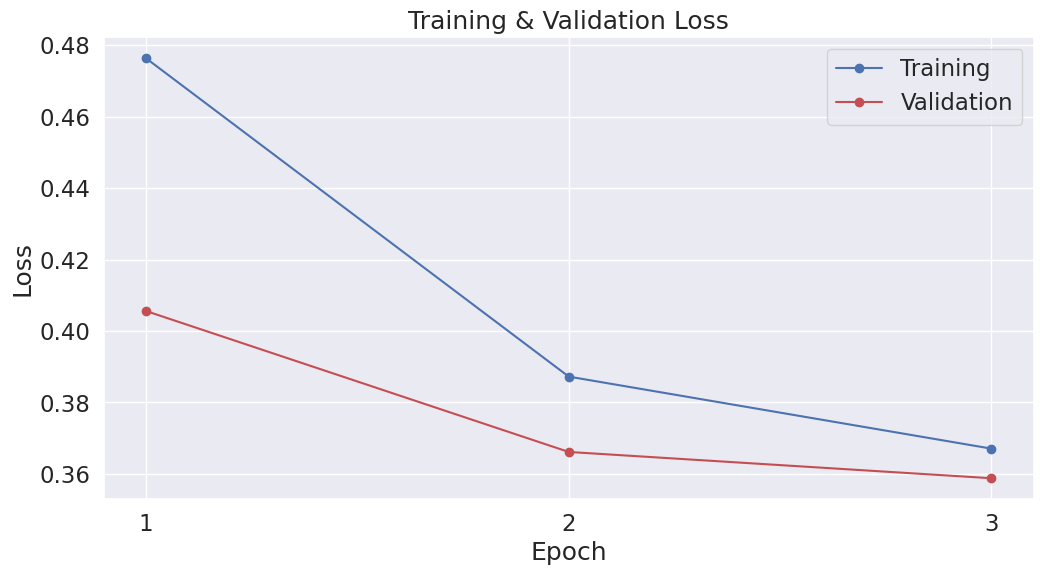

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'r-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

##  Evaluate on Test Set


Predict on test set

In [42]:
print('Predicting labels for {:,} test sentences...'.format(test_size))

model.eval()

predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 507 test sentences...
    DONE.


Our classes are balanced, but still we'll use "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC) just as a popular benchmark.


In [43]:
print('Positive samples: %d of %d (%.2f%%)' % (df.Target.sum(), len(df.Target), (df.Target.sum() / len(df.Target) * 100.0)))

Positive samples: 2531 of 5064 (49.98%)


In [44]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

matthews_set = []

print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)



Calculating Matthews Corr. Coef. for each batch...


View variability in batch metric values


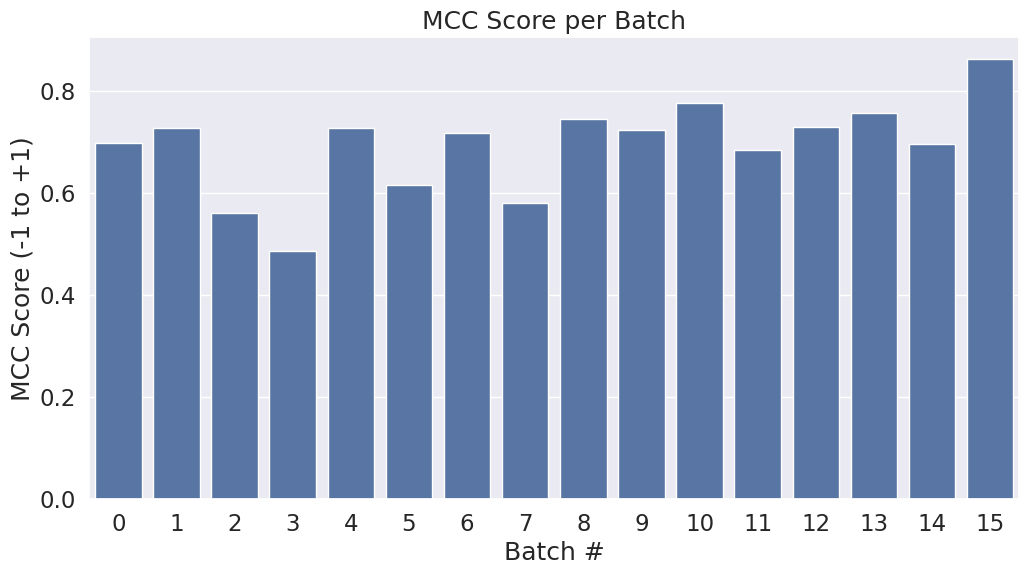

In [45]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, errorbar=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Total MCC score

In [46]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.697


In [67]:
acc = accuracy_score(flat_true_labels, flat_predictions)

print('Total Accuracy: %.3f' % acc)

Total Accuracy: 0.830


##  Saving & Loading Fine-Tuned Model


In [47]:
import os

output_dir = './finetuned_transformers/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

## Import the saved model and test

In [48]:
!pip install transformers

from transformers import BertForSequenceClassification

output_dir = 'finetuned_transformers'

print(output_dir)

model_save


In [49]:
from transformers import BertTokenizer
import torch

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [110]:
sent = "Через $D дней списан $F рублей" # "списан" is the incorrect form here
encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True, # Construct attention masks.
                        return_tensors = 'pt',
                   )

input_id = encoded_dict['input_ids']
attention_mask = encoded_dict['attention_mask']
input_id = torch.LongTensor(input_id)
attention_mask = torch.LongTensor(attention_mask)

In [111]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded = model_loaded.to(device)
input_id = input_id.to(device)
attention_mask = attention_mask.to(device)

In [112]:
with torch.no_grad():
  outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

logits = outputs[0]
index = logits.argmax()
if index == 1:
  print("Gramatically in-correct")
else:
  print("Gramatically correct")


Gramatically in-correct


Still works poorly on more complex grammatically incorrect cases. Could probably achieve slightly better results with param tuning or better preprocessing.